In [1]:
import yfinance as yf
import requests
import json
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
from sklearn. preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn. preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

In [2]:

# Data extraction parameters
ticker = 'BTC-USD'
start_date = '2022-04-01'
end_date = '2023-04-01'
api_key = 'demo'

# Returns a dataframe with stock market data and its normalized sentiment score

def datacreate(t, s, e, a):
    stock_data = yf.download(t, start=s, end=e)
    stock_data  # Stock market data from Yahoo Finance
    url = f'https://eodhistoricaldata.com/api/sentiments?s={t}.cc&from={s}&to={e}&api_token={a}'
    r = requests.get(url)
    dj = r.json()  # Financial News Sentiment Data from EODHD
    dj = json.dumps(dj)
    f = json.loads(dj)
    df = pd.DataFrame(f['BTC-USD.CC'])
    df = df.loc[::-1]
    df = df.reset_index(drop=True)
    df = df.rename(columns={'date': 'Date', 'normalized': 'Sentiment'})
    df['Date'] = pd.to_datetime(df['Date'])
    df_merged = pd.merge(stock_data, df, on='Date', how='left')
    df_merged = df_merged.fillna(0)
    return df_merged


dataset = datacreate(ticker, start_date, end_date, api_key)

dataset


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,count,Sentiment
0,2022-04-01,45554.164062,46616.242188,44403.140625,46281.644531,46281.644531,38162644287,29.0,0.3169
1,2022-04-02,46285.500000,47028.281250,45782.511719,45868.949219,45868.949219,29336594194,10.0,0.3688
2,2022-04-03,45859.128906,47313.476562,45634.105469,46453.566406,46453.566406,25414397610,8.0,-0.1265
3,2022-04-04,46445.273438,46791.089844,45235.816406,46622.675781,46622.675781,32499785455,38.0,0.2087
4,2022-04-05,46624.507812,47106.140625,45544.808594,45555.992188,45555.992188,29640604055,46.0,0.2811
...,...,...,...,...,...,...,...,...,...
360,2023-03-27,27994.068359,28037.925781,26606.689453,27139.888672,27139.888672,18188895178,28.0,0.0453
361,2023-03-28,27132.888672,27460.718750,26677.818359,27268.130859,27268.130859,17783600385,27.0,-0.1232
362,2023-03-29,27267.031250,28619.542969,27259.662109,28348.441406,28348.441406,20684945906,18.0,0.1235
363,2023-03-30,28350.140625,29159.902344,27720.160156,28033.562500,28033.562500,22435349951,22.0,0.1612


In [3]:
# Create features without sentiment data
# Set Target Variable
output_var = pd.DataFrame(dataset['Adj Close'])
# Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

Epoch 1/100
332/332 [==============================] - 2s 2ms/step - loss: 604832960.0000
Epoch 2/100
332/332 [==============================] - 1s 2ms/step - loss: 604320704.0000
Epoch 3/100
332/332 [==============================] - 1s 3ms/step - loss: 602878912.0000
Epoch 4/100
332/332 [==============================] - 1s 2ms/step - loss: 600570048.0000
Epoch 5/100
332/332 [==============================] - 1s 3ms/step - loss: 597605376.0000
Epoch 6/100
332/332 [==============================] - 1s 3ms/step - loss: 594102592.0000
Epoch 7/100
332/332 [==============================] - 1s 2ms/step - loss: 590128128.0000
Epoch 8/100
332/332 [==============================] - 1s 2ms/step - loss: 585726208.0000
Epoch 9/100
332/332 [==============================] - 1s 2ms/step - loss: 580928448.0000
Epoch 10/100
332/332 [==============================] - 1s 3ms/step - loss: 575761472.0000
Epoch 11/100
332/332 [==============================] - 1s 3ms/step - loss: 570246080.0000
Epoch 12

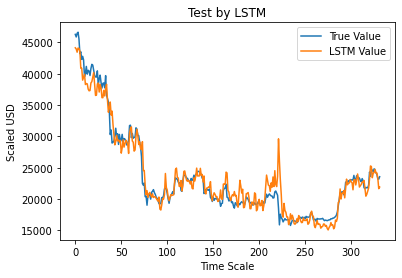

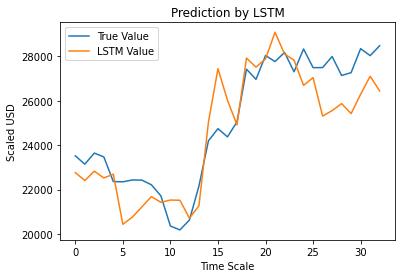

Training Set MSE: 96873762.01
Training Set RMSE: 9842.45
Testing Set MSE: 14770076.20
Testing Set RMSE: 3843.19
Training Set Accuracy: 68.08%
Testing Set Accuracy: 53.65%


In [4]:
# LSTM
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[features])
feature_transform = pd.DataFrame(
    columns=features, data=feature_transform, index=dataset.index)

# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(
        train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(
        train_index): (len(train_index)+len(test_index))].values.ravel()
# Process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(
    1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='Adam')

# Model Training
history = lstm.fit(X_train, y_train, epochs=100,
                   batch_size=1, verbose=1, shuffle=False)

# LSTM Prediction
y_pred_LSTM_N = lstm.predict(X_test)
y_p = lstm.predict(X_train)

# Tested vs True Adj Close Value – LSTM
plt.plot(y_train, label='True Value')
plt.plot(y_p, label='LSTM Value')
plt.title("Test by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred_LSTM_N, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# errors
# Calculating errors or accuracies
train_mse = np.mean(np.square(y_train - y_p))
train_rmse = np.sqrt(train_mse)
test_mse = np.mean(np.square(y_test - y_pred_LSTM_N))
test_rmse = np.sqrt(test_mse)

print("Training Set MSE: {:.2f}".format(train_mse))
print("Training Set RMSE: {:.2f}".format(train_rmse))
print("Testing Set MSE: {:.2f}".format(test_mse))
print("Testing Set RMSE: {:.2f}".format(test_rmse))

train_acc = 100 - (train_rmse / (np.max(y_train) - np.min(y_train)) * 100)
test_acc = 100 - (test_rmse / (np.max(y_test) - np.min(y_test)) * 100)

print("Training Set Accuracy: {:.2f}%".format(train_acc))
print("Testing Set Accuracy: {:.2f}%".format(test_acc))


Epoch 1/100
332/332 [==============================] - 2s 2ms/step - loss: 557960832.0000
Epoch 2/100
332/332 [==============================] - 1s 2ms/step - loss: 60756404.0000
Epoch 3/100
332/332 [==============================] - 1s 2ms/step - loss: 1007345.5625
Epoch 4/100
332/332 [==============================] - 1s 2ms/step - loss: 896939.2500
Epoch 5/100
332/332 [==============================] - 1s 2ms/step - loss: 838355.2500
Epoch 6/100
332/332 [==============================] - 1s 2ms/step - loss: 800583.0625
Epoch 7/100
332/332 [==============================] - 1s 2ms/step - loss: 775018.6250
Epoch 8/100
332/332 [==============================] - 1s 2ms/step - loss: 757369.1250
Epoch 9/100
332/332 [==============================] - 1s 2ms/step - loss: 745299.5000
Epoch 10/100
332/332 [==============================] - 1s 2ms/step - loss: 737360.3125
Epoch 11/100
332/332 [==============================] - 1s 2ms/step - loss: 732422.1250
Epoch 12/100
332/332 [=============

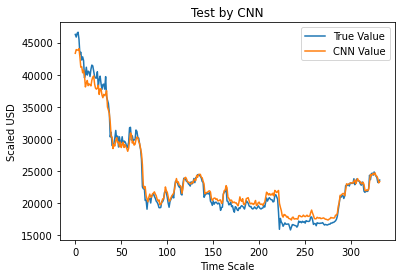

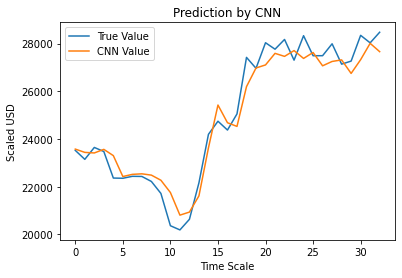

Training Set MSE: 92757377.25
Training Set RMSE: 9631.06
Testing Set MSE: 13031678.14
Testing Set RMSE: 3609.94
Training Set Accuracy: 68.77%
Testing Set Accuracy: 56.46%


In [5]:
# CNN
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[features])
feature_transform = pd.DataFrame(
    columns=features, data=feature_transform, index=dataset.index)

# Split into training and test sets
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(
        train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(
        train_index): (len(train_index)+len(test_index))].values.ravel()

# Reshape the input data for CNN
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = testX.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1))
cnn.compile(loss='mean_squared_error', optimizer='Adam')

# Train the CNN model
history = cnn.fit(X_train, y_train, epochs=100,
                  batch_size=1, verbose=1, shuffle=False)

# Make predictions with the CNN model
y_pred_CNN_N = cnn.predict(X_test)
y_p = cnn.predict(X_train)

# Plot Tested vs true Adj Close values - CNN
plt.plot(y_train, label='True Value')
plt.plot(y_p, label='CNN Value')
plt.title("Test by CNN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Plot predicted vs true Adj Close values - CNN
plt.plot(y_test, label='True Value')
plt.plot(y_pred_CNN_N, label='CNN Value')
plt.title("Prediction by CNN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# error
train_mse = np.mean(np.square(y_train - y_p))
train_rmse = np.sqrt(train_mse)
test_mse = np.mean(np.square(y_test - y_pred_CNN_N))
test_rmse = np.sqrt(test_mse)

print("Training Set MSE: {:.2f}".format(train_mse))
print("Training Set RMSE: {:.2f}".format(train_rmse))
print("Testing Set MSE: {:.2f}".format(test_mse))
print("Testing Set RMSE: {:.2f}".format(test_rmse))

train_acc = 100 - (train_rmse / (np.max(y_train) - np.min(y_train)) * 100)
test_acc = 100 - (test_rmse / (np.max(y_test) - np.min(y_test)) * 100)

print("Training Set Accuracy: {:.2f}%".format(train_acc))
print("Testing Set Accuracy: {:.2f}%".format(test_acc))

Epoch 1/100
332/332 [==============================] - 2s 2ms/step - loss: 603648448.0000
Epoch 2/100
332/332 [==============================] - 1s 2ms/step - loss: 578301632.0000
Epoch 3/100
332/332 [==============================] - 1s 2ms/step - loss: 491952992.0000
Epoch 4/100
332/332 [==============================] - 1s 2ms/step - loss: 339597600.0000
Epoch 5/100
332/332 [==============================] - 1s 2ms/step - loss: 171899328.0000
Epoch 6/100
332/332 [==============================] - 1s 2ms/step - loss: 57593256.0000
Epoch 7/100
332/332 [==============================] - 1s 2ms/step - loss: 13311690.0000
Epoch 8/100
332/332 [==============================] - 1s 2ms/step - loss: 4281544.5000
Epoch 9/100
332/332 [==============================] - 0s 1ms/step - loss: 3089823.5000
Epoch 10/100
332/332 [==============================] - 0s 1ms/step - loss: 2827086.0000
Epoch 11/100
332/332 [==============================] - 1s 2ms/step - loss: 2667133.0000
Epoch 12/100
332/3

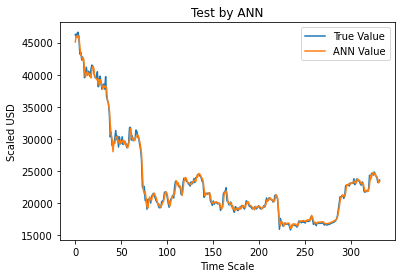

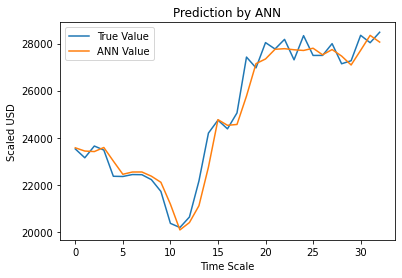

Training Set MSE: 102342650.21
Training Set RMSE: 10116.45
Testing Set MSE: 14348369.41
Testing Set RMSE: 3787.92
Training Set Accuracy: 67.19%
Testing Set Accuracy: 54.31%


In [6]:
# ANN
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[features])
feature_transform = pd.DataFrame(
    columns=features, data=feature_transform, index=dataset.index)

# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(
        train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(
        train_index): (len(train_index)+len(test_index))].values.ravel()

# Building the ANN Model
ann = Sequential()
ann.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1))
ann.compile(loss='mean_squared_error', optimizer='Adam')

# Model Training
history = ann.fit(X_train, y_train, epochs=100,
                  batch_size=1, verbose=1, shuffle=False)

# ANN Prediction
y_pred_ANN_N = ann.predict(X_test)
y_p = ann.predict(X_train)

# Tested vs True Adj Close Value – ANN
plt.plot(y_train, label='True Value')
plt.plot(y_p, label='ANN Value')
plt.title("Test by ANN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Predicted vs True Adj Close Value – ANN
plt.plot(y_test, label='True Value')
plt.plot(y_pred_ANN_N, label='ANN Value')
plt.title("Prediction by ANN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# error
train_mse = np.mean(np.square(y_train - y_p))
train_rmse = np.sqrt(train_mse)
test_mse = np.mean(np.square(y_test - y_pred_ANN_N))
test_rmse = np.sqrt(test_mse)

print("Training Set MSE: {:.2f}".format(train_mse))
print("Training Set RMSE: {:.2f}".format(train_rmse))
print("Testing Set MSE: {:.2f}".format(test_mse))
print("Testing Set RMSE: {:.2f}".format(test_rmse))

train_acc = 100 - (train_rmse / (np.max(y_train) - np.min(y_train)) * 100)
test_acc = 100 - (test_rmse / (np.max(y_test) - np.min(y_test)) * 100)

print("Training Set Accuracy: {:.2f}%".format(train_acc))
print("Testing Set Accuracy: {:.2f}%".format(test_acc))

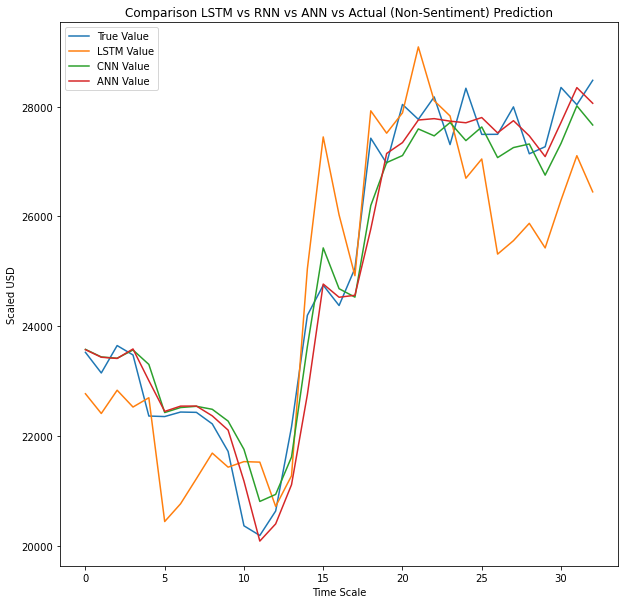

In [7]:
# Compare all three to actual price
plt.figure(figsize=(10, 10))
plt.plot(y_test, label='True Value')
plt.plot(y_pred_LSTM_N, label='LSTM Value')
plt.plot(y_pred_CNN_N, label='CNN Value')
plt.plot(y_pred_ANN_N, label='ANN Value')
plt.title("Comparison LSTM vs RNN vs ANN vs Actual (Non-Sentiment) Prediction")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [8]:
# Create features with sentiment data
# Set Target Variable
output_var = pd.DataFrame(dataset['Adj Close'])
# Selecting the Features
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment']

Epoch 1/100
332/332 [==============================] - 5s 3ms/step - loss: 604782592.0000
Epoch 2/100
332/332 [==============================] - 1s 3ms/step - loss: 603606080.0000
Epoch 3/100
332/332 [==============================] - 1s 4ms/step - loss: 600791744.0000
Epoch 4/100
332/332 [==============================] - 1s 4ms/step - loss: 596643968.0000
Epoch 5/100
332/332 [==============================] - 1s 3ms/step - loss: 591413504.0000
Epoch 6/100
332/332 [==============================] - 1s 4ms/step - loss: 585301760.0000
Epoch 7/100
332/332 [==============================] - 1s 3ms/step - loss: 578412352.0000
Epoch 8/100
332/332 [==============================] - 1s 3ms/step - loss: 570816960.0000
Epoch 9/100
332/332 [==============================] - 1s 3ms/step - loss: 562574720.0000
Epoch 10/100
332/332 [==============================] - 1s 2ms/step - loss: 553736704.0000
Epoch 11/100
332/332 [==============================] - 1s 3ms/step - loss: 544347968.0000
Epoch 12

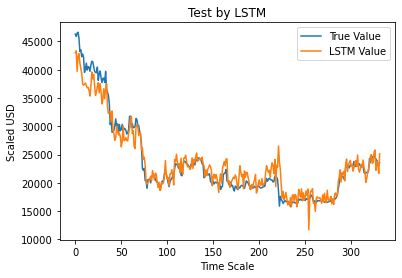

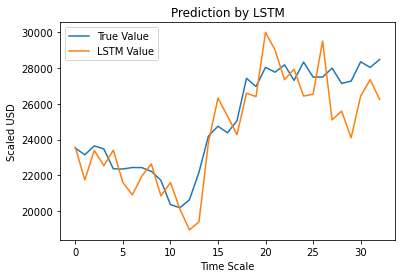

Training Set MSE: 88756233.72
Training Set RMSE: 9421.05
Testing Set MSE: 16108296.46
Testing Set RMSE: 4013.51
Training Set Accuracy: 69.45%
Testing Set Accuracy: 51.59%


In [9]:
# LSTM
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[features])
feature_transform = pd.DataFrame(
    columns=features, data=feature_transform, index=dataset.index)

# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(
        train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(
        train_index): (len(train_index)+len(test_index))].values.ravel()
# Process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(
    1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='Adam')


# Model Training
history = lstm.fit(X_train, y_train, epochs=100,
                   batch_size=1, verbose=1, shuffle=False)

# LSTM Prediction
y_pred_LSTM_S = lstm.predict(X_test)
y_p = lstm.predict(X_train)

# Tested vs True Adj Close Value – LSTM
plt.plot(y_train, label='True Value')
plt.plot(y_p, label='LSTM Value')
plt.title("Test by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred_LSTM_S, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# error
train_mse = np.mean(np.square(y_train - y_p))
train_rmse = np.sqrt(train_mse)
test_mse = np.mean(np.square(y_test - y_pred_LSTM_S))
test_rmse = np.sqrt(test_mse)

print("Training Set MSE: {:.2f}".format(train_mse))
print("Training Set RMSE: {:.2f}".format(train_rmse))
print("Testing Set MSE: {:.2f}".format(test_mse))
print("Testing Set RMSE: {:.2f}".format(test_rmse))

train_acc = 100 - (train_rmse / (np.max(y_train) - np.min(y_train)) * 100)
test_acc = 100 - (test_rmse / (np.max(y_test) - np.min(y_test)) * 100)

print("Training Set Accuracy: {:.2f}%".format(train_acc))
print("Testing Set Accuracy: {:.2f}%".format(test_acc))

Epoch 1/100
332/332 [==============================] - 2s 2ms/step - loss: 581906304.0000
Epoch 2/100
332/332 [==============================] - 1s 2ms/step - loss: 165509984.0000
Epoch 3/100
332/332 [==============================] - 1s 2ms/step - loss: 2625713.2500
Epoch 4/100
332/332 [==============================] - 1s 2ms/step - loss: 1392272.8750
Epoch 5/100
332/332 [==============================] - 1s 3ms/step - loss: 1170166.6250
Epoch 6/100
332/332 [==============================] - 1s 3ms/step - loss: 1026822.3750
Epoch 7/100
332/332 [==============================] - 1s 3ms/step - loss: 934699.0625
Epoch 8/100
332/332 [==============================] - 1s 3ms/step - loss: 874559.5000
Epoch 9/100
332/332 [==============================] - 1s 3ms/step - loss: 834554.6250
Epoch 10/100
332/332 [==============================] - 1s 3ms/step - loss: 807539.5625
Epoch 11/100
332/332 [==============================] - 1s 3ms/step - loss: 789084.8750
Epoch 12/100
332/332 [=========

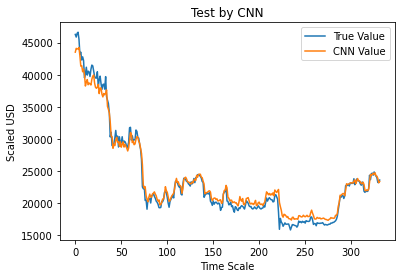

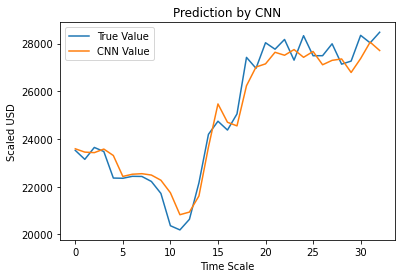

Training Set MSE: 93390948.47
Training Set RMSE: 9663.90
Testing Set MSE: 13112926.39
Testing Set RMSE: 3621.18
Training Set Accuracy: 68.66%
Testing Set Accuracy: 56.33%


In [10]:
# CNN
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[features])
feature_transform = pd.DataFrame(
    columns=features, data=feature_transform, index=dataset.index)

# Split into training and test sets
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(
        train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(
        train_index): (len(train_index)+len(test_index))].values.ravel()

# Reshape the input data for CNN
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = testX.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1))
cnn.compile(loss='mean_squared_error', optimizer='Adam')

# Train the CNN model
history = cnn.fit(X_train, y_train, epochs=100,
                  batch_size=1, verbose=1, shuffle=False)

# Make predictions with the CNN model
y_pred_CNN_S = cnn.predict(X_test)
y_p = cnn.predict(X_train)

# Plot Tested vs true Adj Close values - CNN
plt.plot(y_train, label='True Value')
plt.plot(y_p, label='CNN Value')
plt.title("Test by CNN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Plot predicted vs true Adj Close values - CNN
plt.plot(y_test, label='True Value')
plt.plot(y_pred_CNN_S, label='CNN Value')
plt.title("Prediction by CNN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# error
train_mse = np.mean(np.square(y_train - y_p))
train_rmse = np.sqrt(train_mse)
test_mse = np.mean(np.square(y_test - y_pred_CNN_S))
test_rmse = np.sqrt(test_mse)

print("Training Set MSE: {:.2f}".format(train_mse))
print("Training Set RMSE: {:.2f}".format(train_rmse))
print("Testing Set MSE: {:.2f}".format(test_mse))
print("Testing Set RMSE: {:.2f}".format(test_rmse))

train_acc = 100 - (train_rmse / (np.max(y_train) - np.min(y_train)) * 100)
test_acc = 100 - (test_rmse / (np.max(y_test) - np.min(y_test)) * 100)

print("Training Set Accuracy: {:.2f}%".format(train_acc))
print("Testing Set Accuracy: {:.2f}%".format(test_acc))

Epoch 1/100
332/332 [==============================] - 3s 2ms/step - loss: 602874496.0000
Epoch 2/100
332/332 [==============================] - 1s 2ms/step - loss: 562393152.0000
Epoch 3/100
332/332 [==============================] - 1s 2ms/step - loss: 432337824.0000
Epoch 4/100
332/332 [==============================] - 1s 2ms/step - loss: 237772480.0000
Epoch 5/100
332/332 [==============================] - 1s 2ms/step - loss: 83887800.0000
Epoch 6/100
332/332 [==============================] - 1s 2ms/step - loss: 21384404.0000
Epoch 7/100
332/332 [==============================] - 1s 2ms/step - loss: 8280600.0000
Epoch 8/100
332/332 [==============================] - 1s 2ms/step - loss: 6010530.5000
Epoch 9/100
332/332 [==============================] - 1s 2ms/step - loss: 5219754.5000
Epoch 10/100
332/332 [==============================] - 1s 2ms/step - loss: 4653162.5000
Epoch 11/100
332/332 [==============================] - 1s 2ms/step - loss: 4142307.0000
Epoch 12/100
332/332

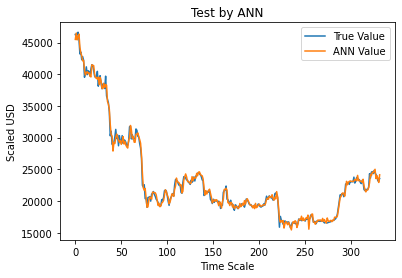

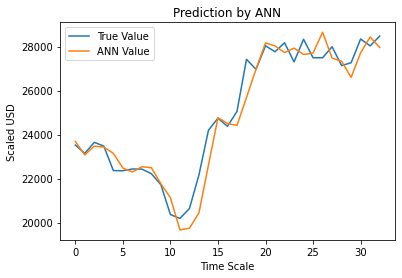

Training Set MSE: 102942615.32
Training Set RMSE: 10146.06
Testing Set MSE: 15245150.02
Testing Set RMSE: 3904.50
Training Set Accuracy: 67.10%
Testing Set Accuracy: 52.91%


In [11]:
# ANN
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset[features])
feature_transform = pd.DataFrame(
    columns=features, data=feature_transform, index=dataset.index)

# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(
        train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(
        train_index): (len(train_index)+len(test_index))].values.ravel()

# Building the ANN Model
ann = Sequential()
ann.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1))
ann.compile(loss='mean_squared_error', optimizer='Adam')

# Model Training
history = ann.fit(X_train, y_train, epochs=100,
                  batch_size=1, verbose=1, shuffle=False)

# ANN Prediction
y_pred_ANN_S = ann.predict(X_test)
y_p = ann.predict(X_train)

# Tested vs True Adj Close Value – ANN
plt.plot(y_train, label='True Value')
plt.plot(y_p, label='ANN Value')
plt.title("Test by ANN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Predicted vs True Adj Close Value – ANN
plt.plot(y_test, label='True Value')
plt.plot(y_pred_ANN_S, label='ANN Value')
plt.title("Prediction by ANN")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# error
train_mse = np.mean(np.square(y_train - y_p))
train_rmse = np.sqrt(train_mse)
test_mse = np.mean(np.square(y_test - y_pred_ANN_S))
test_rmse = np.sqrt(test_mse)

print("Training Set MSE: {:.2f}".format(train_mse))
print("Training Set RMSE: {:.2f}".format(train_rmse))
print("Testing Set MSE: {:.2f}".format(test_mse))
print("Testing Set RMSE: {:.2f}".format(test_rmse))

train_acc = 100 - (train_rmse / (np.max(y_train) - np.min(y_train)) * 100)
test_acc = 100 - (test_rmse / (np.max(y_test) - np.min(y_test)) * 100)

print("Training Set Accuracy: {:.2f}%".format(train_acc))
print("Testing Set Accuracy: {:.2f}%".format(test_acc))

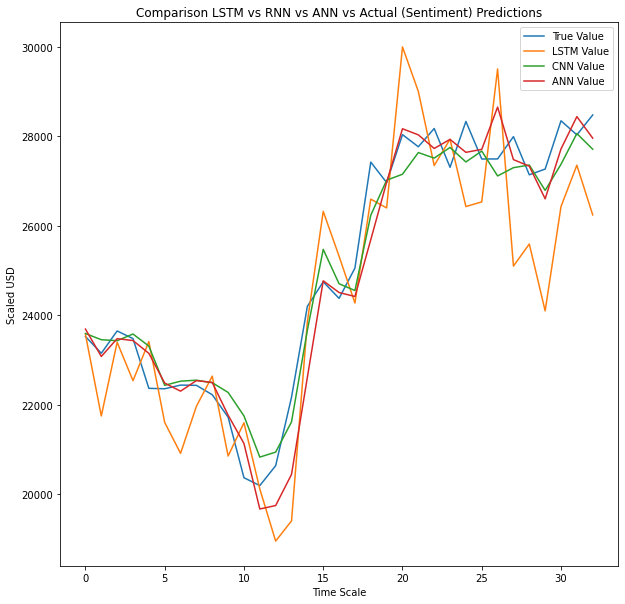

In [12]:
# Compare all three to actual price
plt.figure(figsize=(10, 10))
plt.plot(y_test, label='True Value')
plt.plot(y_pred_LSTM_S, label='LSTM Value')
plt.plot(y_pred_CNN_S, label='CNN Value')
plt.plot(y_pred_ANN_S, label='ANN Value')
plt.title("Comparison LSTM vs RNN vs ANN vs Actual (Sentiment) Predictions")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

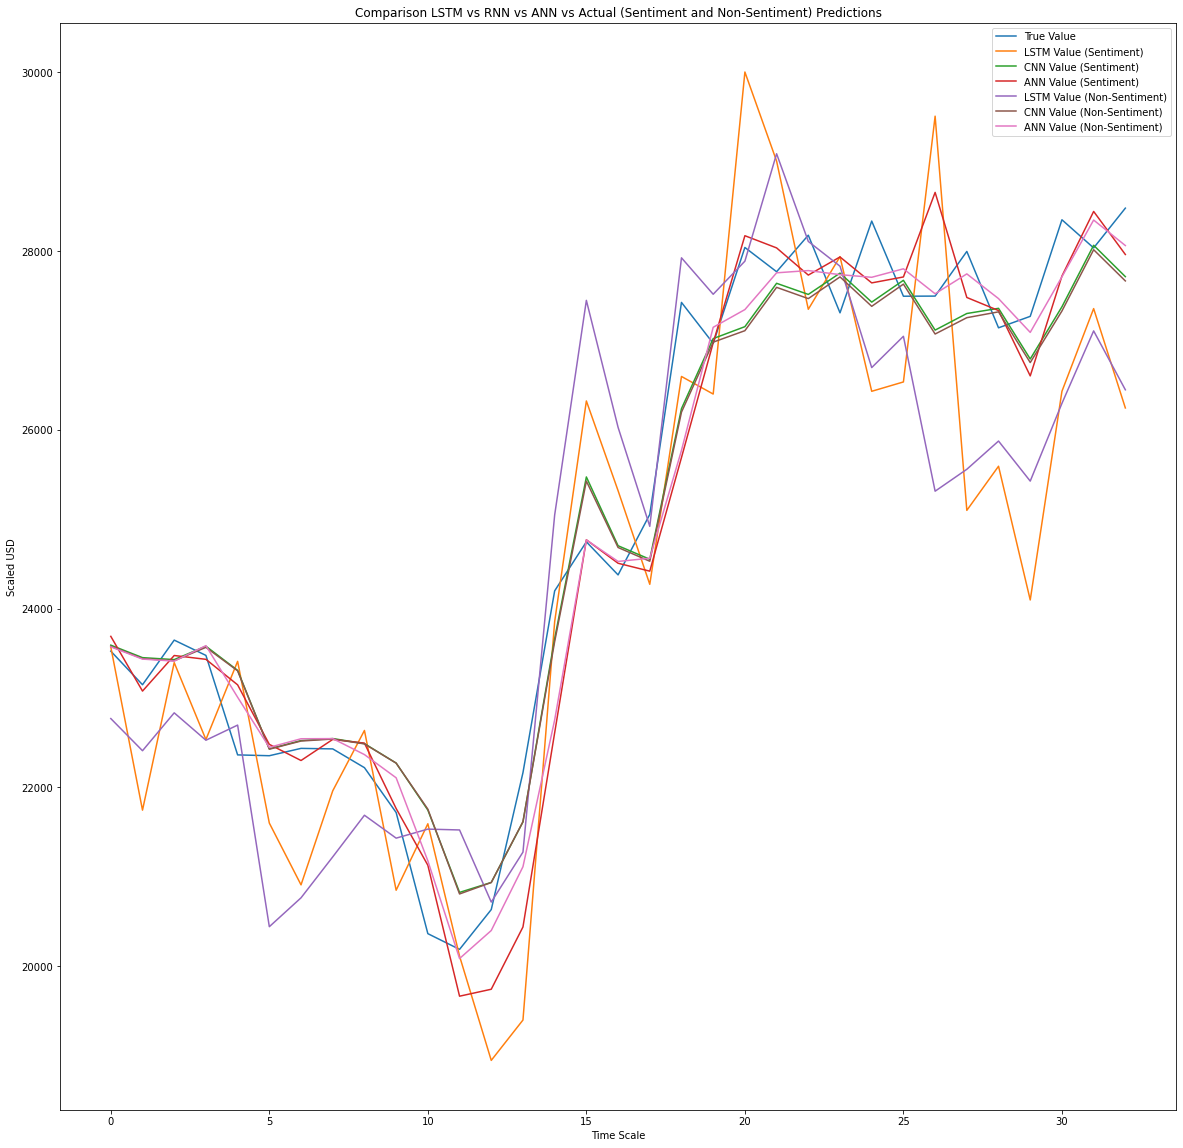

In [13]:
# Compare all six to actual price
plt.figure(figsize=(20, 20))
plt.plot(y_test, label='True Value')
plt.plot(y_pred_LSTM_S, label='LSTM Value (Sentiment)')
plt.plot(y_pred_CNN_S, label='CNN Value (Sentiment)')
plt.plot(y_pred_ANN_S, label='ANN Value (Sentiment)')
plt.plot(y_pred_LSTM_N, label='LSTM Value (Non-Sentiment)')
plt.plot(y_pred_CNN_N, label='CNN Value (Non-Sentiment)')
plt.plot(y_pred_ANN_N, label='ANN Value (Non-Sentiment)')
plt.title(
    "Comparison LSTM vs RNN vs ANN vs Actual (Sentiment and Non-Sentiment) Predictions")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()